In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from functions import load_and_combine_csvs
from functions import clean_dataframe
from functions import add_confidential_flags
from functions import apply_state_estimation

### Criando Dataframe e Aplicando Funções

In [23]:
csv_path = '../raw_data'

df = load_and_combine_csvs(csv_path)

df_limpo = clean_dataframe(df)

df_limpo = add_confidential_flags(df_limpo)

df_limpo = apply_state_estimation(df_limpo)

In [24]:
df_limpo

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO_ORIGEM,SIGILOSO,DATA_IMPUTADA,ESTADO_ESTIMADO
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,41023473000191,41.023.473 EDUARDO MIRANDA DE OLIVEIRA,COMPRA A/V - R$ - APRES,2023-04-24,1350.00,202305_CPGF.csv,0,0,UNIÃO
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,8605945000149,FERRAGISTA CAPITAL LTDA,COMPRA A/V - R$ - APRES,2023-03-29,163.00,202305_CPGF.csv,0,0,UNIÃO
2,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,3597528376,ROSINALDA MOREIRA DE SOUSA,COMPRA A/V - R$ - APRES,2023-04-05,315.00,202305_CPGF.csv,0,0,UNIÃO
3,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.866.951-**,JONAS SCHOTTZ DA SILVA,1008713000679,FUJIOKA ELETRO IMAGEM S.A,COMPRA A/V - R$ - APRES,2023-03-28,69.80,202305_CPGF.csv,0,0,UNIÃO
4,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.523.712-**,SORAYA RITA DO AMARAL GARCIA VIANNA,4945481000169,IMPORTADORA OPLIMA LTDA,COMPRA A/V - R$ - APRES,2023-03-28,700.00,202305_CPGF.csv,0,0,UNIÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392084,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,10,***.077.598-**,RONALDO DA SILVA FERNANDES,6239994000180,AUTO POSTO PARQUE VILLA LOBOS LTDA.,COMPRA A/V - R$ - APRES,2024-09-19,218.70,202410_CPGF.csv,0,0,PR
392085,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,10,***.077.598-**,RONALDO DA SILVA FERNANDES,6239994000180,AUTO POSTO PARQUE VILLA LOBOS LTDA.,COMPRA A/V - R$ - APRES,2024-09-13,212.48,202410_CPGF.csv,0,0,PR
392086,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,10,***.077.598-**,RONALDO DA SILVA FERNANDES,6239994000180,AUTO POSTO PARQUE VILLA LOBOS LTDA.,COMPRA A/V - R$ - APRES,2024-09-12,256.04,202410_CPGF.csv,0,0,PR
392087,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,10,***.077.598-**,RONALDO DA SILVA FERNANDES,6239994000180,AUTO POSTO PARQUE VILLA LOBOS LTDA.,COMPRA A/V - R$ - APRES,2024-09-11,237.45,202410_CPGF.csv,0,0,PR


### Funções de Processamento de Dados

In [25]:
def build_features(df):
    df = df.copy()

    df['valor_log'] = np.log1p(df['VALOR TRANSAÇÃO'])
    df['mes'] = df['DATA TRANSAÇÃO'].dt.month
    df['dia_semana'] = df['DATA TRANSAÇÃO'].dt.weekday

    features = ['valor_log','mes','dia_semana']
    return df, features

In [26]:
def scale_features(df, features):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])
    return X, scaler

In [27]:
def run_isolation_forest(X):
    model = IsolationForest(contamination=0.01, random_state=42)
    preds = model.fit_predict(X)
    scores = model.decision_function(X)
    return preds, scores, model

In [28]:
def build_ranking(df):
    df['score_final'] = (
        df['iso_score'].rank(pct=True)
    )
    return df.sort_values('score_final').reset_index(drop=True)

### Processamento de Dados e Criação do Modelo

#### criar cópia de dataframe sem os dados com datas imputadas

In [29]:
df_final = df_limpo[df_limpo['DATA_IMPUTADA'] == 0].copy()

In [30]:
df_final, features = build_features(df_final)

In [31]:
df_final.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO_ORIGEM,SIGILOSO,DATA_IMPUTADA,ESTADO_ESTIMADO,valor_log,mes,dia_semana
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,COMPRA A/V - R$ - APRES,2023-04-24,1350.0,202305_CPGF.csv,0,0,UNIÃO,7.208600,4,0
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,COMPRA A/V - R$ - APRES,2023-03-29,163.0,202305_CPGF.csv,0,0,UNIÃO,5.099866,3,2


In [32]:
features

['valor_log', 'mes', 'dia_semana']

In [33]:
X, scaler = scale_features(df_final, features)

In [34]:
X

array([[ 1.3636408 , -0.92416869, -1.42397329],
       [-0.29992793, -1.25308338, -0.10325545],
       [ 0.21748891, -0.92416869, -0.10325545],
       ...,
       [ 0.0545739 ,  0.72040472,  0.55710347],
       [-0.00465005,  0.72040472, -0.10325545],
       [-0.15030427,  0.72040472, -1.42397329]], shape=(289417, 3))

In [35]:
scaler

,copy,True
,with_mean,True
,with_std,True


In [36]:
iso_preds, iso_scores, iso_model = run_isolation_forest(X)

In [37]:
df_final['iso_score'] = iso_scores
df_final['iso_pred'] = iso_preds

In [38]:
df_final.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,VALOR TRANSAÇÃO,ARQUIVO_ORIGEM,SIGILOSO,DATA_IMPUTADA,ESTADO_ESTIMADO,valor_log,mes,dia_semana,iso_score,iso_pred
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,1350.0,202305_CPGF.csv,0,0,UNIÃO,7.208600,4,0,0.094489,1
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,163.0,202305_CPGF.csv,0,0,UNIÃO,5.099866,3,2,0.170255,1


In [39]:
df_ranked = build_ranking(df_final)
suspeitas = df_ranked.head(200)

In [40]:
suspeitas.head()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ARQUIVO_ORIGEM,SIGILOSO,DATA_IMPUTADA,ESTADO_ESTIMADO,valor_log,mes,dia_semana,iso_score,iso_pred,score_final
0,52000,Ministério da Defesa,52121,Comando do Exército,160131,17 REGIMENTO DE CAVALARIA MECANIZADO,2024,2,***.163.736-**,MARLLON BRENDO DO CARMO MOREIRA,...,202402_CPGF.csv,0,0,UNIÃO,1.658228,1,6,-0.095053,-1,0.000003
1,52000,Ministério da Defesa,52131,Comando da Marinha,791010,CENTRO DE INTENDEN. DA MARINHA EM NITEROI,2025,2,***.743.047-**,GABRIEL MANTOANO FELIX DE SOUZA,...,202502_CPGF.csv,0,0,RJ,9.311870,1,6,-0.086510,-1,0.000007
2,26000,Ministério da Educação,26435,"Instituto Federal de Educação, Ciência e Tecno...",158369,INST.FED.DO RN/CAMPUS NATAL - CENTRAL,2023,1,***.920.884-**,FLANELSON MACIEL MONTEIRO,...,202301_CPGF.csv,0,0,RS,2.292535,12,6,-0.086253,-1,0.000010
3,52000,Ministério da Defesa,52121,Comando do Exército,160432,CENTRO DE LOGISTICA DE MISSEIS E FOGUETES,2024,12,***.165.491-**,CARLOS HENRIQUE DE MORAES,...,202412_CPGF.csv,0,0,UNIÃO,0.262364,11,6,-0.086151,-1,0.000014
4,49000,Ministério do Desenvolvimento Agrário e Agr,22201,Instituto Nacional de Colonização e Reforma Ag...,373055,SUPERINTENDENCIA REG.DE MINAS GERAIS - SR(MG),2024,1,***.956.616-**,ADILSON DOS REIS,...,202401_CPGF.csv,0,0,DF,2.322388,12,6,-0.083807,-1,0.000019


In [41]:
suspeitas[['VALOR TRANSAÇÃO', 'score_final']].describe()

,VALOR TRANSAÇÃO,score_final
count,200.000000,200.000000
mean,2058.294700,0.000347
std,5721.237283,0.000200
min,0.060000,0.000003
25%,2.780000,0.000175
50%,6.600000,0.000347
75%,26.752500,0.000520
max,55824.000000,0.000691


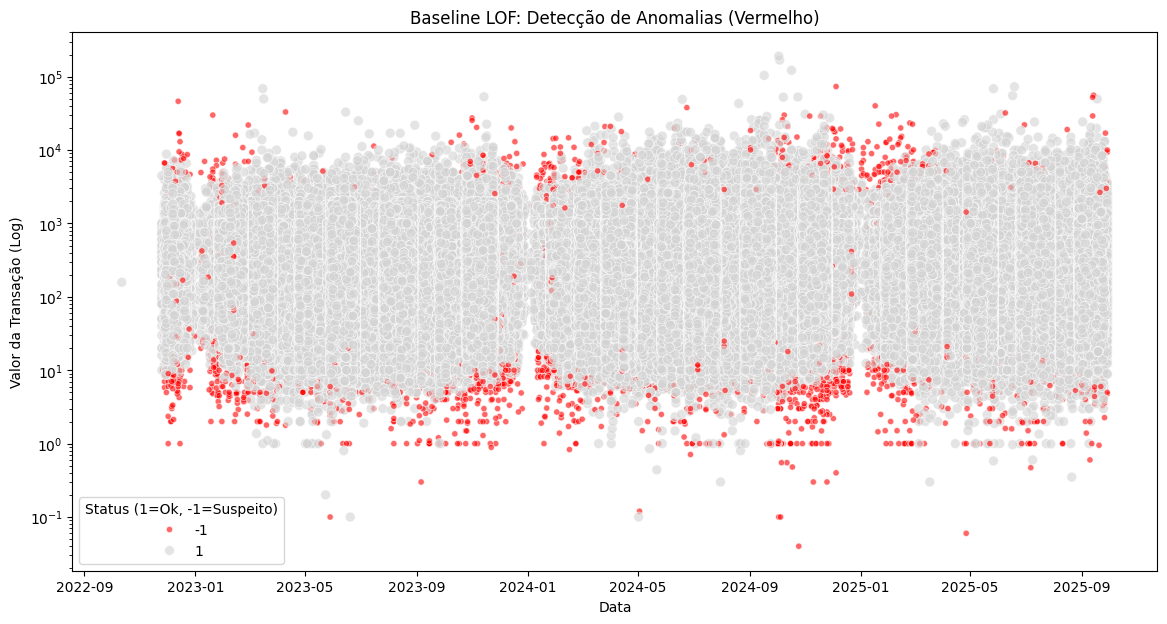

In [42]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_final,
    x='DATA TRANSAÇÃO',
    y='VALOR TRANSAÇÃO',
    hue='iso_pred',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='iso_pred',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline LOF: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Data')
plt.legend(title='Status (1=Ok, -1=Suspeito)')
plt.show()